In [1]:
!pip install pingouin pycirclize
!pip install git+https://github.com/netneurolab/neuromaps.git
!pip install git+https://github.com/netneurolab/pypyls.git@ee5e3e03df4b7fd3ed83f3a858991cc5672d0be5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.3 MB/s eta 0:00:00
  Cloning https://github.com/netneurolab/neuromaps.git to /tmp/pip-req-build-h3tvgdnz
  Running command git clone --filter=blob:none --quiet https://github.com/netneurolab/neuromaps.git /tmp/pip-req-build-h3tvgdnz
  Resolved https://github.com/netneurolab/neuromaps.git to commit f0ed67c44d633061b93c6d337a1b233f6895c408
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 110.0 MB/s eta 0:00:00
  Created wheel for neuromaps: filename=neuromaps-0.0.5+41.gf0ed67c-py3-none-any.whl size=125554 sha256=b632fe16f9add14b3c1205df4bba2525b4fd92490226f061f99e42abeb5d32f5
  Stored in directory: /tmp/pip-ephem-wheel-cache-6v5ehrm4/w

In [2]:
from pathlib import Path
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sstats
import pingouin
from pycirclize import Circos

In [3]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
plt.rcParams['font.size'] = 7
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["svg.fonttype"] = "path"

from matplotlib.colors import ListedColormap, to_rgb, to_hex
pal_bgo_3 = ["#31A9E7", "#305861", "#F19100"]
cmap_bgo_3 = ListedColormap([to_rgb(_) for _ in pal_bgo_3])

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# this is for Zhen-Qi, change it when you run it
data_dir = Path("/content/gdrive/MyDrive/My Documents/Research/Manuscript_EP_RSFC_PLS/Data")
figs_dir = Path("/content/gdrive/MyDrive/My Documents/Research/Manuscript_EP_RSFC_PLS/Figures")

In [5]:
# this is for Haley
data_dir = Path("/content/gdrive/MyDrive/Projects/Manuscript_EP_RSFC_PLS/Data")
figs_dir = Path("/content/gdrive/MyDrive/Projects/Manuscript_EP_RSFC_PLS/Figures")

In [6]:
ep_pls_result = h5py.File(data_dir / "20240917_PLS" / "EP_RSFC_pls_result_PLS_all_200P_GSR_10k.hdf5")

In [7]:
ep_pls_all = pd.read_csv(data_dir / "PLS_all_200P_GSR.csv")

In [8]:
post_hoc = ep_pls_all[["src_subject_id", "cohort", "age_demeaned", "sex", "dup", "med_equiv_current", "dx", "dx_code"]].rename({
    "src_subject_id": "ID",
    "age_demeaned": "age",
    "med_equiv_current": "med",
})

with h5py.File(data_dir / "20240917_PLS" / "EP_RSFC_pls_result_PLS_all_200P_GSR_10k.hdf5") as f:
    post_hoc['LC1_brain'] = f["results"]["x_scores"][:, 0]
    post_hoc['LC1_behv'] = f["results"]["y_scores"][:, 0]

group_names = ["Schizophrenia", "Schizoaffective disorder", "Psychotic mood disorders"]
group_names_short = ["Schizophrenia", "Schizoaffective\ndisorder", "Psychotic mood\ndisorders"]

# Define a function to set the values of column "A" based on column "B"
def set_value(row):
    if row['dx'] in [295.90, 295.40, 298.80, 297.10]:
        return group_names[0]
    elif row["dx"] in [295.70]:
        return group_names[1]
    elif row['dx'] in [296.24, 296.44, 296.89, 296.54, 296.34, 296.40, 296.53]:
        return group_names[2]

# Apply the function to create column "A"
post_hoc['group'] = post_hoc.apply(set_value, axis=1)

post_hoc['group'] = pd.Categorical(post_hoc['group'], categories=group_names, ordered=True)
post_hoc['group_code'] = post_hoc['group'].cat.codes

x_scores_grouped = [post_hoc['LC1_brain'].to_numpy()[np.where(post_hoc["group"] == _)[0]] for _ in group_names]
y_scores_grouped = [post_hoc['LC1_behv'].to_numpy()[np.where(post_hoc["group"] == _)[0]] for _ in group_names]

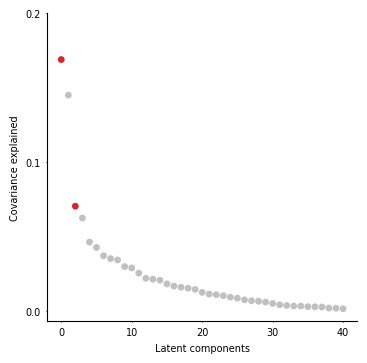

In [9]:
ep_varexp = ep_pls_result["results/varexp"][:]
ep_varexp_pval = ep_pls_result["results/permres/pvals"][:]
ep_varexp_pval_color = ["tab:red" if p<=0.05 else "silver" for p in ep_varexp_pval]

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(range(len(ep_varexp)), ep_varexp, s=15, c=ep_varexp_pval_color)

ax.set(xticks=[0, 10, 20, 30, 40], yticks=[0, 0.1, 0.2],
       xlabel="Latent components", ylabel="Covariance explained")

sns.despine(top=True, right=True, trim=False, ax=ax)
ax.tick_params(axis=u'both', which=u'both', length=1)
fig.savefig(figs_dir / "hcpepgsr_exp_var.svg")

In [42]:
ep_varexp_pval

array([0.00839916, 0.05189481, 0.02679732, 0.56084392, 0.35386461,
       0.44875512, 0.07469253, 0.55894411, 0.33226677, 0.89041096,
       0.81651835, 0.88481152, 0.94110589, 0.61143886, 0.83831617,
       0.82641736, 0.81491851, 0.91310869, 0.89621038, 0.96220378,
       0.75752425, 0.95990401, 0.95430457, 0.97710229, 0.99980002,
       0.96260374, 0.93850615, 0.99410059, 0.99590041, 1.        ,
       0.99920008, 0.99940006, 0.99960004, 0.99870013, 0.99760024,
       0.99980002, 0.99980002, 1.        , 0.99960004, 0.99970003,
       1.        ])

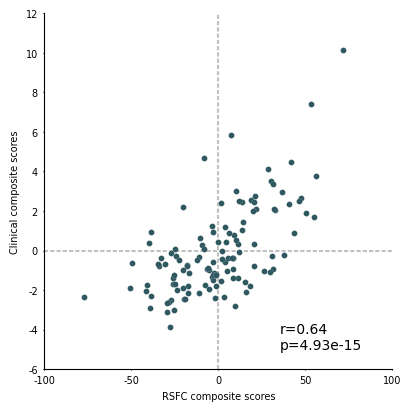

In [11]:
fig, ax = plt.subplots(figsize=(4, 4), layout="constrained")
scatter = ax.scatter(ep_pls_result["results"]["x_scores"][:, 0], ep_pls_result["results"]["y_scores"][:, 0],
                     s=18, color=pal_bgo_3[1], linewidths=0.1, edgecolors='white')
ax.axvline(x=0, c="silver", zorder=0, ls=(0, (2, 1)))
ax.axhline(y=0, c="silver", zorder=0, ls=(0, (2, 1)))

ax.set(xlim=(-100, 100), ylim=(-6, 12), xticks=[-100, -50, 0, 50, 100], yticks=[-6, -4, -2, 0, 2, 4, 6, 8, 10, 12],
       xlabel="RSFC composite scores", ylabel="Clinical composite scores")

score_corr_r, score_corr_p = sstats.pearsonr(ep_pls_result["results"]["x_scores"][:, 0], ep_pls_result["results"]["y_scores"][:, 0])

ax.text(35, -5, f"r={score_corr_r:.2f}\np={score_corr_p:.2e}", fontsize=10)

sns.despine(top=True, right=True, trim=True, ax=ax)
ax.tick_params(axis=u'both', which=u'both', length=1)

fig.savefig(figs_dir / "hcpepgsr_score_corr.svg")

In [12]:
import colorsys

def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

def plot_raincloud(x, ax):
    pos = np.array([1, 2, 3])
    v1 = ax.violinplot(x, positions=pos+0.2,
                    showmeans=False, showextrema=False, showmedians=False)

    for b, c in zip(v1['bodies'], pal_bgo_3):
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
        b.set_facecolor(c)
        b.set_linewidth(0)

    b1 = ax.boxplot(x, positions=pos, patch_artist=True, widths=0.15)

    for item in ['boxes']:
        for patch, c in zip(b1[item], pal_bgo_3):
            plt.setp(patch, facecolor=c, edgecolor=to_hex(scale_lightness(to_rgb(c), 0.75)))
    for item in ['medians']:
        for patch, c in zip(b1[item], pal_bgo_3):
            plt.setp(patch, color=c)
    for item in ['whiskers', 'caps']:
        for i, patch in enumerate(b1[item]):
            c = pal_bgo_3[int(i/2)]
            plt.setp(patch, color=to_hex(scale_lightness(to_rgb(c), 0.75)))
    for item in ['fliers']:
        for patch, c in zip(b1[item], pal_bgo_3):
            plt.setp(patch, markeredgecolor=c)

    e1 = ax.eventplot(x, orientation="vertical", lineoffsets=pos-0.2, linelengths=0.1, colors=pal_bgo_3)

    return v1, b1, e1

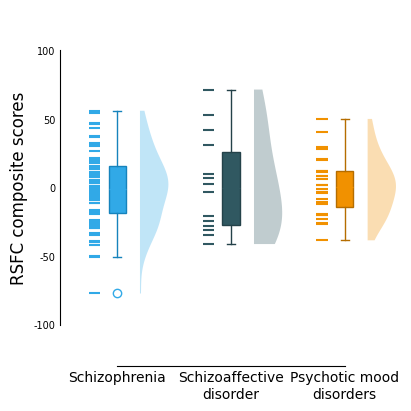

In [13]:
fig, ax = plt.subplots(figsize=(4, 4), layout="constrained")
v1, b1, e1 = plot_raincloud(x_scores_grouped, ax)

ax.set(ylim=(-130, 130), yticks=[-100, -50, 0, 50, 100])
ax.set_ylabel("RSFC composite scores", fontsize=12)
ax.set_xticklabels(group_names_short, fontsize=10)

sns.despine(top=True, right=True, trim=True, ax=ax)
ax.tick_params(axis=u'both', which=u'both', length=0)

fig.savefig(figs_dir / "hcpepgsr_x_scores.svg")

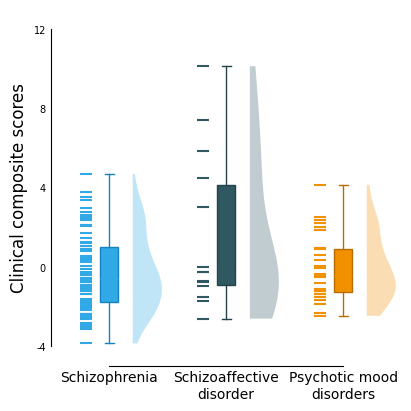

In [14]:
fig, ax = plt.subplots(figsize=(4, 4), layout="constrained")
v1, b1, e1 = plot_raincloud(y_scores_grouped, ax)

ax.set(ylim=(-5, 13), yticks=[-4, 0, 4, 8, 12])
ax.set_ylabel("Clinical composite scores", fontsize=12)
ax.set_xticklabels(group_names_short, fontsize=10)

sns.despine(top=True, right=True, trim=True, ax=ax)
ax.tick_params(axis=u'both', which=u'both',length=0)

fig.savefig(figs_dir / "hcpepgsr_y_scores.svg")

In [15]:
ep_pls_yload = ep_pls_result["results/y_loadings"][:, 0]
ep_pls_yload_err = (
    ep_pls_result["results/bootres/y_loadings_ci"][:, 0, 1]- ep_pls_result["results/bootres/y_loadings_ci"][:, 0, 0]
) / 2

ep_pls_yload_resort = np.argsort(-1 * ep_pls_result["results/y_loadings"][:, 0])
ep_pls_yload_all_idx = np.where(
    (np.abs(ep_pls_yload)-ep_pls_yload_err)>0
    )[0]
ep_pls_yload_top_idx = np.where(
    (np.abs(sstats.zscore(ep_pls_yload)) > 1)
    & ((np.abs(ep_pls_yload)-ep_pls_yload_err)>0)
    )[0]
ep_pls_yload_sq_top_idx = np.where(
    (np.abs(sstats.zscore(ep_pls_yload ** 2)) > 1)
    & ((np.abs(ep_pls_yload)-ep_pls_yload_err)>0)
    )[0]
ep_pls_yload_all_resort = np.argsort(-1 * ep_pls_result["results/y_loadings"][ep_pls_yload_all_idx, 0])
ep_pls_yload_top_resort = np.argsort(-1 * ep_pls_result["results/y_loadings"][ep_pls_yload_top_idx, 0])
ep_pls_yload_sq_top_resort = np.argsort(-1 * ep_pls_result["results/y_loadings"][ep_pls_yload_sq_top_idx, 0])

ep_scores = pd.read_csv(data_dir / "EP_scores.csv")
score_dimension_to_color = {"pos": "#5C554A", "neg": "#31A9E7", "gen": "#345662", "mania": "#F19100"}
ep_scores["text_color"] = ep_scores["dimension"].map(score_dimension_to_color)

for i in range(len(ep_scores)):
    curr_name = ep_scores.loc[i, "description"]
    curr_new = curr_name.split(" ")
    if len(curr_name) >= 40:
        curr_new.insert(-3, "\n")
    elif 40 > len(curr_name) > 23:
        curr_new.insert(-2, "\n")
    ep_scores.loc[i, "description"] = " ".join(curr_new)

In [18]:
temp = pd.DataFrame(columns=['symptoms', 'coef', 'se'])
temp['symptoms'] = ep_scores["description"].to_numpy()
temp['coef'] = ep_pls_yload
temp['se'] = ep_pls_yload_err
temp['top'] = np.abs(sstats.zscore(ep_pls_yload))
temp['sq_top'] = np.abs(sstats.zscore(ep_pls_yload ** 2))
temp['margin'] = np.abs(temp['coef'])-temp['se']
temp[temp['margin']>0.1]

,symptoms,coef,se,top,sq_top,margin
6,Hostility,0.414353,0.149071,1.598249,2.123839,0.265281
15,Anxiety,0.309597,0.174152,0.993942,0.812079,0.135444
16,Guilt Feelings,0.343451,0.168306,1.189239,1.194490,0.175145
22,Unusual Thought Content,0.320470,0.186615,1.056669,0.930582,0.133855
34,Irritability,0.547536,0.131468,2.366547,4.339705,0.416068
36,Language - \n Thought Disorder,0.332917,0.183502,1.128473,1.071254,0.149415
37,Bizzare Content,0.293881,0.180453,0.903281,0.648032,0.113428
38,Disruptive - \n Aggressive Behavior,0.376599,0.181918,1.380458,1.607331,0.194681
39,Appearance,0.312986,0.141076,1.013493,0.848577,0.171910


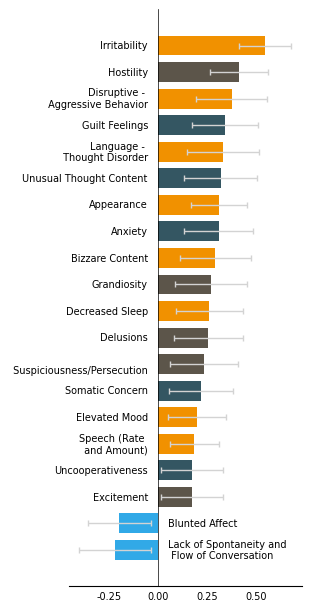

In [19]:
fig, ax = plt.subplots(figsize=(3.0, 6), layout="constrained")

# this was the old one for ep_pls_yload_sq_top_resort
# plot_x = np.arange(len(ep_pls_yload_sq_top_resort))
# plot_y = ep_pls_yload[ep_pls_yload_sq_top_idx][ep_pls_yload_sq_top_resort]
# plot_error = ep_pls_yload_err[ep_pls_yload_sq_top_idx][ep_pls_yload_sq_top_resort]
# plot_y_ticklabels = ep_scores["description"].to_numpy()[ep_pls_yload_sq_top_idx][ep_pls_yload_sq_top_resort]
# plot_y_ticklabels_color = ep_scores["text_color"].to_numpy()[ep_pls_yload_sq_top_idx][ep_pls_yload_sq_top_resort]

# this is the new one
plot_x = np.arange(len(ep_pls_yload_all_resort))
plot_y = ep_pls_yload[ep_pls_yload_all_idx][ep_pls_yload_all_resort]
plot_error = ep_pls_yload_err[ep_pls_yload_all_idx][ep_pls_yload_all_resort]
plot_y_ticklabels = ep_scores["description"].to_numpy()[ep_pls_yload_all_idx][ep_pls_yload_all_resort]
plot_y_ticklabels_color = ep_scores["text_color"].to_numpy()[ep_pls_yload_all_idx][ep_pls_yload_all_resort]

plot_y_pos = np.where(plot_y>0)[0]
plot_y_neg = np.where(plot_y<0)[0]

ax.axvline(x=0, c="black", lw=0.5)

ax.barh(plot_x, plot_y, xerr=plot_error, color=plot_y_ticklabels_color, height=0.75,
        error_kw=dict(ecolor="lightgray", lw=1, capsize=2, capthick=1))
ax.set(xticks=[-0.25, 0, 0.25, 0.5], yticks=plot_x, yticklabels=[])
ax.invert_yaxis()
sns.despine(top=True, right=True, left=True, ax=ax)
ax.tick_params(axis=u'both', which=u'both', length=0)

for i in plot_y_pos:
    ax.text(-0.05, plot_x[i], plot_y_ticklabels[i], ha="right", va="center",
            color="k")
for i in plot_y_neg:
    ax.text(0.05, plot_x[i], plot_y_ticklabels[i], ha="left", va="center",
            color="k")

fig.savefig(figs_dir / "hcpepgsr_yload.svg")

In [20]:
from pycirclize import Circos
ep_scores["yload"] = ep_pls_yload
# ep_pls_yload_sq_top_score_names = ep_scores["description"].to_numpy()[ep_pls_yload_sq_top_idx][ep_pls_yload_sq_top_resort]
ep_pls_yload_all_score_names = ep_scores["description"].to_numpy()[ep_pls_yload_all_idx][ep_pls_yload_all_resort]

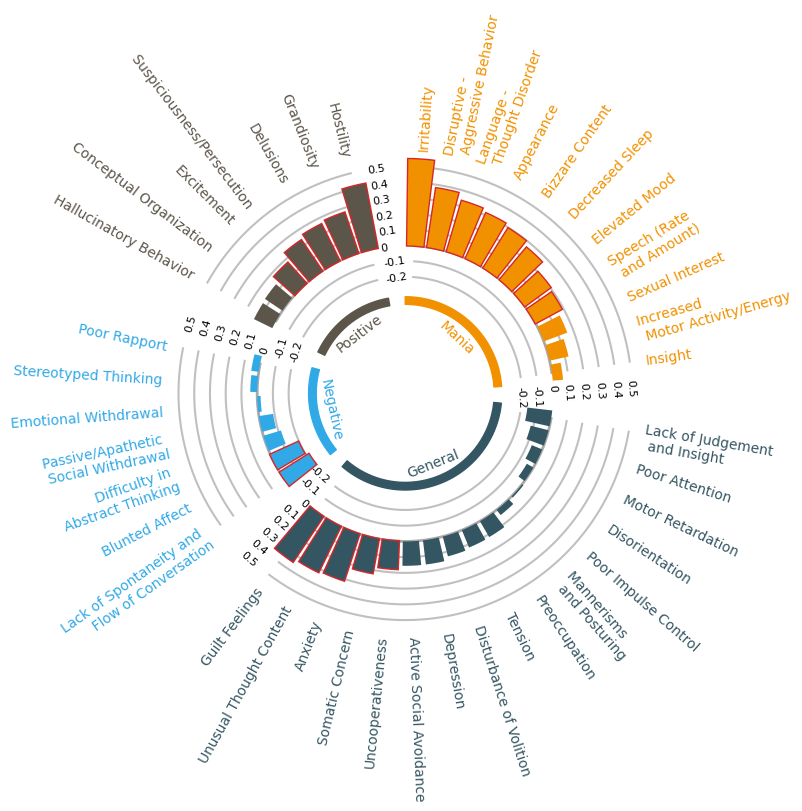

In [21]:
with matplotlib.rc_context({"svg.fonttype": "path"}):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'}, layout="constrained")

    sectors = {"Mania": 11, "General": 16, "Negative": 7, "Positive": 7}
    circos = Circos(
        sectors, space=10,
        sector2clockwise = {"Positive": False, "Negative": False, "General": False, "Mania": True}
        )

    for sector, dim in zip(circos.sectors, ["mania", "gen", "neg", "pos"]):

        sector.rect(r_lim=(35, 38), color=score_dimension_to_color[dim])
        sector.text(f"{sector.name}", r=27, size=10, color=score_dimension_to_color[dim])

        curr_ep_scores = ep_scores[ep_scores["dimension"]==dim]
        # if dim == "neg":
        #     curr_ep_scores = curr_ep_scores.sort_values("neg_domains")
        # sort
        curr_ep_scores = curr_ep_scores.sort_values("yload", ascending=False)

        plot_x = np.arange(len(curr_ep_scores)) + 0.5
        plot_y = curr_ep_scores["yload"].to_numpy()
        plot_ylabel = curr_ep_scores["description"].to_numpy()
        vmin, vmax = -0.25, 0.55

        track = sector.add_track((40, 95), r_pad_ratio=0.1)
        # track.axis()
        track.xticks(plot_x, plot_ylabel, label_orientation="vertical", tick_length=0,
                    text_kws={"color": score_dimension_to_color[dim]}, label_size=10)
        track.yticks(y=[-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5], vmin=vmin, vmax=vmax,
                    labels=[-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5], tick_length=0)

        track.line(plot_x, [0]*len(plot_x), vmin=vmin, vmax=vmax, arc=True, color="darkgray", lw=2, zorder=1)
        for i in [-0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5]:
            track.line(plot_x, [i]*len(plot_x), vmin=vmin, vmax=vmax, arc=True, color="silver", zorder=1)
        track.bar(plot_x, plot_y, vmin=vmin, vmax=vmax, color=score_dimension_to_color[dim], zorder=3)

        plot_ylabel_sig_idx = [i for i, _ in enumerate(plot_ylabel) if _ in ep_pls_yload_all_score_names]
        for curr_idx in plot_ylabel_sig_idx:
            track.bar([plot_x[curr_idx]], [plot_y[curr_idx]], vmin=vmin, vmax=vmax, zorder=2, linewidth=2, edgecolor="tab:red")

    fig = circos.plotfig(ax=ax)
    fig.savefig(figs_dir / "hcpepgsr_yload_circle.svg")

In [22]:
ep_yload_vec = np.load(data_dir / "20240917_PLS" / "EP_RSFC_pls_loadings_PLS_all_200P_GSR_10k_xload_y_loadings_lv0.npy")
ep_yload_ci0_vec, ep_yload_ci1_vec = np.load(data_dir / "20240917_PLS" / "EP_RSFC_pls_loadings_PLS_all_200P_GSR_10k_xload_bootres_y_loadings_ci_lv0.npy").T

In [23]:
# recover the matrix from the vector

iu = np.triu_indices(216, 1)
iu_mat = np.zeros((216, 216))
iu_mat[iu] = 1

def vec_to_mat(vec):
    mat = np.zeros((216, 216))
    mat[iu] = vec.squeeze()
    mat += mat.T
    return mat

ep_yload_mat = vec_to_mat(ep_yload_vec)
ep_yload_ci0_mat = vec_to_mat(ep_yload_ci0_vec)
ep_yload_ci1_mat = vec_to_mat(ep_yload_ci1_vec)

ep_yload_symerror_mat = (ep_yload_ci1_mat - ep_yload_ci0_mat) / 2
ep_yload_ci_mat = np.abs(ep_yload_mat) - ep_yload_symerror_mat
ep_yload_sig_mat = (ep_yload_ci_mat > 0).astype(int)

In [24]:
# try to reorder the matrix and label

raw_data = np.array(ep_yload_mat)
raw_data_sig = np.array(ep_yload_sig_mat)
raw_labels = []
raw_labels_colors = []
with open(data_dir / "Schaefer2018_200Parcels_17Networks_order_Tian_Subcortex_S1_label.txt", "r") as f:
    _raw = f.readlines()
_raw = [_.strip() for _ in _raw]
for i in range(216):
    raw_labels.append([_raw[2*i], *_raw[2*i+1].split(" ")])

# reorder the raw labels and matrices for plotting
labels_reordered_1 = np.loadtxt(data_dir / "labels_reordered_1.txt", dtype=str)
labels_reordered_1 = [_.strip() for _ in labels_reordered_1]

labels_reordered_2 = np.loadtxt(data_dir / "labels_reordered_2.txt", dtype=str)
labels_reordered_2 = [_.strip() for _ in labels_reordered_2]

curr_order = [_[0] for _ in raw_labels]
reorder_idx_1 = [curr_order.index(_) for _ in labels_reordered_1]
reorder_idx_2 = [curr_order.index(_) for _ in labels_reordered_2]

# do not run this again separately

# raw_labels = [raw_labels[_] for _ in reorder_idx_1]
# ep_yload_mat = ep_yload_mat[np.ix_(reorder_idx_1, reorder_idx_1)]
# ep_yload_sig_mat = ep_yload_sig_mat[np.ix_(reorder_idx_1, reorder_idx_1)]


# here we reorder by "labels_reordered_2.txt"
reordered_labels = [raw_labels[_] for _ in reorder_idx_2]
reordered_data = raw_data[np.ix_(reorder_idx_2, reorder_idx_2)]
reordered_data_sig = raw_data_sig[np.ix_(reorder_idx_2, reorder_idx_2)]

tmp_idx_for_reordered_2 = [0, 12, 24, 43, 58, 70, 80, 96, 106, 112, 120, 136, 151, 157, 171, 188, 194, 200, 216]
tmp_labels_for_reordered_2 = [
    'VisCent',
    'VisPeri',
    'SomMotA',
    'SomMotB',
    'DorsAttnA',
    'DorsAttnB',
    'SalVentAttnA',
    'SalVentAttnB',
    'LimbicB',
    'LimbicA',
    'ContA',
    'ContB',
    'ContC',
    'DefaultA',
    'DefaultB',
    'DefaultC',
    'TempPar',
    'subc'
]

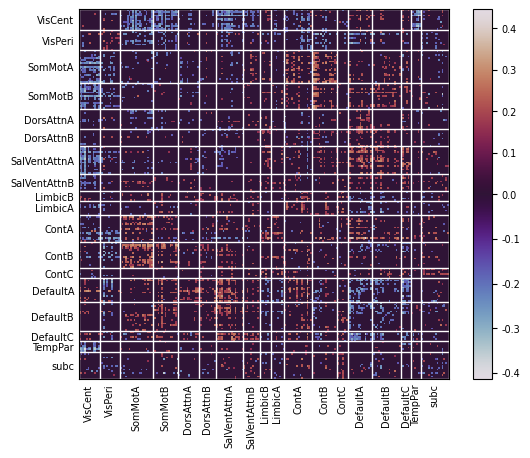

In [25]:
# matrices visualization
import matplotlib.colors as mcolors
plot_mat = reordered_data * reordered_data_sig  # only show the significant values
norm = mcolors.TwoSlopeNorm(vmin=np.min(plot_mat), vcenter=0., vmax=np.max(plot_mat))

fig, ax = plt.subplots()
pcm = ax.pcolormesh(plot_mat, norm=norm, cmap="twilight", rasterized=True)
# pcm.set_clim(0, 1)
ax.invert_yaxis()
ax.set_aspect("equal")
plt.colorbar(pcm, ax=ax)

for v in tmp_idx_for_reordered_2:
    if v == 0 or v == 216: pass
    ax.axvline(x=v, c="white", lw=1)
    ax.axhline(y=v, c="white", lw=1)

ticks = (np.array(tmp_idx_for_reordered_2[1:]) + np.array(tmp_idx_for_reordered_2[:-1]))/2

ax.set(xticks=ticks, xticklabels=tmp_labels_for_reordered_2);
ax.set(yticks=ticks, yticklabels=tmp_labels_for_reordered_2);
ax.tick_params(axis='both', which='both', length=0)
ax.tick_params(axis='x', labelrotation=90)
ax.tick_params(axis='y', labelrotation=0)

fig.savefig(figs_dir / "hcpepgsr_xload_sig_matrix.svg", dpi=400)

In [ ]:
# circos visualization

In [26]:
# hacks to get the resting-state network names & colors & indices

rsn_labels = []
for v in reordered_labels:
    if "-lh" in v[0]:
        rsn_labels.append("LH_subc")
    elif "-rh" in v[0]:
        rsn_labels.append("RH_subc")
    else:
        rsn_labels.append("_".join(v[0].split("_")[1:3]))

rsn_labels_unique, rsn_labels_first_idx, rsn_labels_count = [], {}, {}
rsn_colors = {}
for i, v in enumerate(rsn_labels):
    if v not in rsn_labels_unique:
        rsn_labels_unique.append(v)
        rsn_labels_first_idx[v] = i
        rsn_labels_count[v] = 1
        rsn_colors[v] = list(map(int, reordered_labels[i][2:5]))
    else:
        rsn_labels_count[v] += 1

for k in rsn_colors.keys():
    rsn_colors[k] = list(np.array(rsn_colors[k])/255)

In [27]:
tmp_labels_count_for_reordered_2 = {}
for v in tmp_labels_for_reordered_2:
    tmp_labels_count_for_reordered_2[v] = rsn_labels_count["LH_"+v] + rsn_labels_count["RH_"+v]

# def indice_to_linkline(i):
#     curr_sector = rsn_labels[i]
#     curr_idx = i - rsn_labels.index(curr_sector)  # this would be the first appearance
#     return (curr_sector, curr_idx)

def indice_to_linkline_for_reordered_2(i):
    curr_sector = rsn_labels[i].split("_")[1]
    curr_idx = i - rsn_labels.index("LH_"+curr_sector)  # LH always appear first so it's fine to use the index
    return (curr_sector, curr_idx)

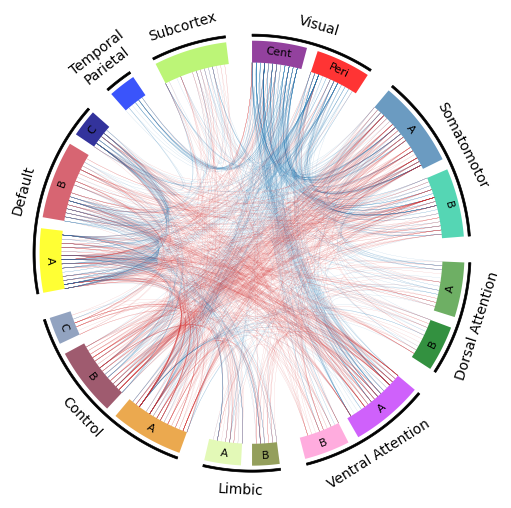

In [28]:
plot_mat = reordered_data * reordered_data_sig

# HERE I TOOK TOP 2.5 PERCENT CONNECTIONS
# had to do this since it's much more dense than Kebets
plot_mat[
    (plot_mat<np.percentile(plot_mat, 97.5)) & (plot_mat>np.percentile(plot_mat, 2.5))
] = 0


fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': 'polar'}, layout="constrained")

sectors = tmp_labels_count_for_reordered_2
name2color = rsn_colors
from pycirclize.utils import calc_group_spaces
sector_groups = [
    (['VisCent', 'VisPeri'], "Visual"),
    (['SomMotA', 'SomMotB'], "Somatomotor"),
    (['DorsAttnA', 'DorsAttnB'], "Dorsal Attention"),
    (['SalVentAttnA', 'SalVentAttnB'], "Ventral Attention"),
    (['LimbicB', 'LimbicA'], "Limbic"),
    (['ContA', 'ContB', 'ContC'], "Control"),
    (['DefaultA', 'DefaultB', 'DefaultC'], "Default"),
    (['TempPar'], "Temporal\nParietal"),
    (['subc'], "Subcortex")
]
sector_subnames = {
    'VisCent': "Cent",
    'VisPeri': "Peri",
    'SomMotA': "A",
    'SomMotB': "B",
    'DorsAttnA': "A",
    'DorsAttnB': "B",
    'SalVentAttnA': "A",
    'SalVentAttnB': "B",
    'LimbicB': "B",
    'LimbicA': "A",
    'ContA': "A",
    'ContB': "B",
    'ContC': "C",
    'DefaultA': "A",
    'DefaultB': "B",
    'DefaultC': "C",
    'TempPar': "",
    'subc': ""
}
spaces = calc_group_spaces([2, 2, 2, 2, 2, 3, 3, 1, 1], space_bw_group=7, space_in_group=3)
circos = Circos(sectors, space=spaces)
for sector in circos.sectors:
    region = sector.name
    sector.text(f"{sector_subnames[region]}", size=8, r=90, color="black", va="center")
    track = sector.add_track((87, 97))
    track.axis(fc=name2color["LH_"+region], lw=0, alpha=0.8)

for idx, group in enumerate(sector_groups):
    group_values, group_name = group
    group_deg_lim = circos.get_group_sectors_deg_lim(group_values)
    circos.rect(r_lim=(99, 100), deg_lim=group_deg_lim, fc="black", ec=None, lw=0.5)
    group_center_deg = sum(group_deg_lim) / 2
    circos.text(f"{group_name}", r=105, deg=group_center_deg, adjust_rotation=True, size=10)


curr_plot_indices = list(zip(*np.where(plot_mat * iu_mat)))
curr_plot_linklines = [[indice_to_linkline_for_reordered_2(i), indice_to_linkline_for_reordered_2(j)] for i, j in curr_plot_indices]
for ij_it, ij in enumerate(curr_plot_linklines):
    i, j = ij
    color = "tab:red" if plot_mat[curr_plot_indices[ij_it]] > 0 else "tab:blue"
    circos.link_line(i, j, color=color, lw=0.1, alpha=0.5)

fig = circos.plotfig(ax=ax)
fig.savefig(figs_dir / "hcpepgsr_xload_topconn_circos.svg")

In [30]:
rsn_coeff_mat = np.zeros((len(tmp_labels_for_reordered_2), len(tmp_labels_for_reordered_2)))
rsn_count_mat = np.zeros_like(rsn_coeff_mat)
rsn_allcount_mat = np.zeros_like(rsn_coeff_mat)
for i in range(216):
    ii = tmp_labels_for_reordered_2.index(rsn_labels[i].split("_")[1])
    for j in range(216):
        jj = tmp_labels_for_reordered_2.index(rsn_labels[j].split("_")[1])
        rsn_allcount_mat[ii, jj] += 1
        if reordered_data_sig[i, j] > 0:
            rsn_count_mat[ii, jj] += 1
            rsn_coeff_mat[ii, jj] += reordered_data[i, j]
rsn_coeff_avg_mat = rsn_coeff_mat / rsn_count_mat
rsn_count_sigratio_mat = rsn_count_mat / rsn_allcount_mat

<ipython-input-30-45c452054d13>:12: RuntimeWarning: invalid value encountered in divide
  rsn_coeff_avg_mat = rsn_coeff_mat / rsn_count_mat


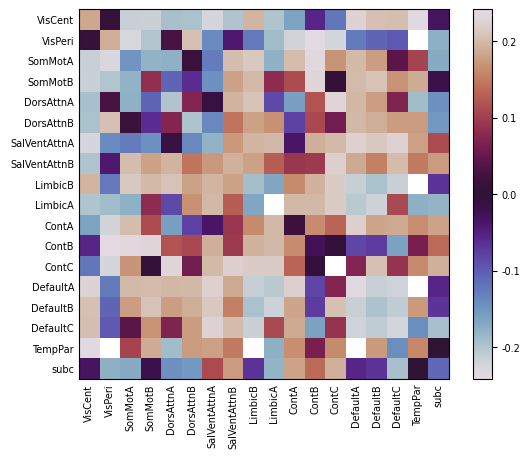

In [31]:
# the circos connections plot is not always an accurate representation of the full picture
# it only shows some top connections but not their strengths
# here shows the average connection strength between networks
# (color limit can be tuned)
# see next one also

plot_mat = rsn_coeff_avg_mat.copy()
fig, ax = plt.subplots()
pcm = ax.pcolormesh(plot_mat, cmap="twilight", rasterized=True)
cmax = max(np.abs(np.nanmin(plot_mat)), np.nanmax(plot_mat))
pcm.set_clim(-1*cmax, cmax)
ax.invert_yaxis()
ax.set_aspect("equal")
plt.colorbar(pcm, ax=ax)

ticks = np.arange(18) + 0.5

ax.set(xticks=ticks, xticklabels=tmp_labels_for_reordered_2);
ax.set(yticks=ticks, yticklabels=tmp_labels_for_reordered_2);
ax.tick_params(axis='both', which='both', length=0)
ax.tick_params(axis='x', labelrotation=90)
ax.tick_params(axis='y', labelrotation=0)

fig.savefig(figs_dir / "hcpepgsr_xload_rsn_coeffavg_mat.svg", dpi=400)

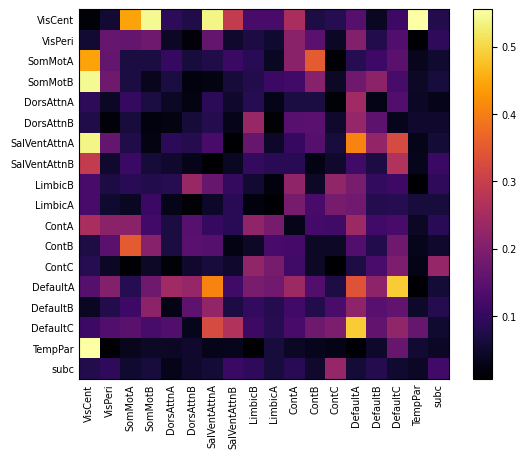

In [32]:
# the circos plot also does not accurately show which networks are more significantly connected proportionally
# the "darker" lines in the circos plot could be sometimes misleading
# here is the percentage of significant connections between the networks
# (color limit can be tuned)

plot_mat = rsn_count_sigratio_mat.copy()
fig, ax = plt.subplots()
pcm = ax.pcolormesh(plot_mat, cmap="inferno", rasterized=True)
pcm.set_clim(np.nanpercentile(plot_mat, 2.5), np.nanmax(plot_mat))
ax.invert_yaxis()
ax.set_aspect("equal")
plt.colorbar(pcm, ax=ax)

ticks = np.arange(18) + 0.5

ax.set(xticks=ticks, xticklabels=tmp_labels_for_reordered_2);
ax.set(yticks=ticks, yticklabels=tmp_labels_for_reordered_2);
ax.tick_params(axis='both', which='both', length=0)
ax.tick_params(axis='x', labelrotation=90)
ax.tick_params(axis='y', labelrotation=0)

fig.savefig(figs_dir / "hcpepgsr_xload_rsn_sigratio_mat.svg", dpi=400)

In [51]:
rsn_mat_to_sort = np.array(rsn_coeff_avg_mat)
rsn_mat_to_sort_iu = np.triu_indices(18, 0)
rsn_mat_vec = rsn_mat_to_sort[rsn_mat_to_sort_iu]
rsn_mat_vec_names = [(tmp_labels_for_reordered_2[_[0]], tmp_labels_for_reordered_2[_[1]]) for _ in zip(*rsn_mat_to_sort_iu)]

rsn_mat_vec_top_idx = np.where(
    (np.abs(sstats.zscore(rsn_mat_vec, nan_policy="omit")) > 1.2)
    )[0]
rsn_mat_vec_top_resort = np.argsort(-1 * rsn_mat_vec[rsn_mat_vec_top_idx])

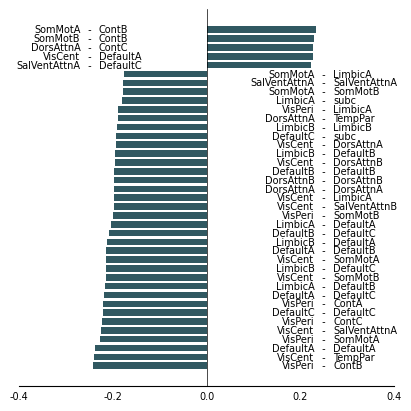

In [53]:
fig, ax = plt.subplots(figsize=(4.0, 4), layout="constrained")

plot_x = np.arange(len(rsn_mat_vec_top_resort))
plot_y = rsn_mat_vec[rsn_mat_vec_top_idx][rsn_mat_vec_top_resort]
plot_y_ticklabels = np.array(rsn_mat_vec_names)[rsn_mat_vec_top_idx][rsn_mat_vec_top_resort]
# plot_y_ticklabels_color = ep_scores["text_color"].to_numpy()[rsn_mat_vec_top_idx][rsn_mat_vec_top_resort]

plot_y_pos = np.where(plot_y>0)[0]
plot_y_neg = np.where(plot_y<0)[0]

ax.axvline(x=0, c="black", lw=0.5)

ax.barh(plot_x, plot_y, color=pal_bgo_3[1], height=0.75,
        error_kw=dict(ecolor="lightgray", lw=1, capsize=2, capthick=1))
ax.set(xticks=[-0.4, -0.2, 0, 0.2, 0.4], yticks=plot_x, yticklabels=[])
ax.invert_yaxis()
sns.despine(top=True, right=True, left=True, ax=ax)
ax.tick_params(axis=u'both', which=u'both', length=0)

for i in plot_y_pos:
    ax.text(-0.23, plot_x[i], plot_y_ticklabels[i][1], ha="left", va="center", color="k")
    ax.text(-0.25, plot_x[i], " - ", ha="center", va="center", color="k")
    ax.text(-0.27, plot_x[i], plot_y_ticklabels[i][0], ha="right", va="center", color="k")

for i in plot_y_neg:
    ax.text(0.27, plot_x[i], plot_y_ticklabels[i][1], ha="left", va="center", color="k")
    ax.text(0.25, plot_x[i], " - ", ha="center", va="center", color="k")
    ax.text(0.23, plot_x[i], plot_y_ticklabels[i][0], ha="right", va="center", color="k")

fig.savefig(figs_dir / "hcpepgsr_xload_rsn_topconn_bar.svg")